In [2]:
import pandas as pd
import numpy as np
import linopy
import pypsa

In [3]:
import tqdm

In [4]:
from pypsa.descriptors import get_switchable_as_dense as as_dense

In [5]:
def replace_su(network, su_to_replace):

    su = network.storage_units.loc[su_to_replace]

    bus_name = "{} {}".format(su["bus"], su["carrier"])
    link_1_name = "{} converter {} to AC".format(su_to_replace, su["carrier"])
    link_2_name = "{} converter AC to {}".format(su_to_replace, su["carrier"])
    store_name = "{} store {}".format(su_to_replace, su["carrier"])
    gen_name = "{} inflow".format(su_to_replace)

    if bus_name not in network.buses.index:
        network.add("Bus", bus_name, carrier=su["carrier"])

    # dispatch link
    network.add(
        "Link",
        link_1_name,
        bus0=bus_name,
        bus1=su["bus"],
        capital_cost=su["capital_cost"] * su["efficiency_dispatch"],
        p_nom=su["p_nom"] / su["efficiency_dispatch"],
        p_nom_extendable=su["p_nom_extendable"],
        p_nom_max=su["p_nom_max"] / su["efficiency_dispatch"],
        p_nom_min=su["p_nom_min"] / su["efficiency_dispatch"],
        p_max_pu=su["p_max_pu"],
        marginal_cost=su["marginal_cost"] * su["efficiency_dispatch"],
        efficiency=su["efficiency_dispatch"],
        carrier = su["carrier"],
        type="discharging",
    )

    # store link
    network.add(
        "Link",
        link_2_name,
        bus1=bus_name,
        bus0=su["bus"],
        p_nom=su["p_nom"],
        p_nom_extendable=su["p_nom_extendable"],
        p_nom_max=su["p_nom_max"],
        p_nom_min=su["p_nom_min"],
        p_max_pu=-su["p_min_pu"],
        efficiency=su["efficiency_store"],
        carrier = su["carrier"],
        type="charging"
    )

    if (
        su_to_replace in network.storage_units_t.state_of_charge_set.columns
        and (
            ~pd.isnull(network.storage_units_t.state_of_charge_set[su_to_replace])
        ).any()
    ):
        e_max_pu = pd.Series(data=1.0, index=network.snapshots)
        e_min_pu = pd.Series(data=0.0, index=network.snapshots)
        non_null = ~pd.isnull(
            network.storage_units_t.state_of_charge_set[su_to_replace]
        )
        e_max_pu[non_null] = network.storage_units_t.state_of_charge_set[su_to_replace][
            non_null
        ]
        e_min_pu[non_null] = network.storage_units_t.state_of_charge_set[su_to_replace][
            non_null
        ]
    else:
        e_max_pu = 1.0
        e_min_pu = 0.0

    network.add(
        "Store",
        store_name,
        bus=bus_name,
        e_nom=su["p_nom"] * su["max_hours"],
        e_nom_min=su["p_nom_min"] / su["efficiency_dispatch"] * su["max_hours"],
        e_nom_max=su["p_nom_max"] / su["efficiency_dispatch"] * su["max_hours"],
        e_nom_extendable=su["p_nom_extendable"],
        e_max_pu=e_max_pu,
        e_min_pu=e_min_pu,
        standing_loss=su["standing_loss"],
        e_cyclic=su["cyclic_state_of_charge"],
        e_initial=su["state_of_charge_initial"],
        carrier = su["carrier"]
    )


    # inflow from a variable generator, which can be curtailed (i.e. spilled)
    inflow_max = as_dense(network, "StorageUnit", "inflow").max()[su_to_replace]
    
    if inflow_max == 0.0:
        inflow_pu = 0.0
    else:
        inflow_pu = network.storage_units_t.inflow[su_to_replace] / inflow_max

    if inflow_max >0:
        network.add(
            "Generator",
            gen_name,
            bus=bus_name,
            carrier="rain",
            p_nom=inflow_max,
            p_max_pu=inflow_pu,
        )
        
    network.add(
        "Generator",
        gen_name + " loss-of-charge",
        bus=bus_name,
        carrier= su["carrier"],
        p_nom=su["p_nom"] * su["max_hours"],
        marginal_cost = 200,
        type="loss-of-charge",
        )
    
    network.add(
        "Generator",
        gen_name + " spillage",
        bus=bus_name,
        carrier= su["carrier"],
        p_nom=su["p_nom"] * su["max_hours"],
        p_min_pu = -1,
        p_max_pu = 0,
        marginal_cost = -200,
        type="spillage",
        )

    network.remove("StorageUnit", su_to_replace)

In [38]:
n_full = pypsa.Network("resources/networks/0/cy1984_ty2026.nc")

INFO:pypsa.io:Imported network cy1984_ty2026.nc has buses, generators, links, loads, storage_units


In [39]:
n_full.set_snapshots(n_full.snapshots[:48])

In [40]:
for su in n_full.storage_units.index:
    replace_su(n_full, su);

In [41]:
n_full.stores.e_cyclic = True

In [42]:
n_full.madd("Generator", n_full.buses.index + " load-shedding", carrier="lost-load", bus=n_full.buses.index, p_nom=1e6, marginal_cost=10e3)
n_full.madd("Generator", n_full.buses.index + " gen-shedding", carrier="lost-gen", bus=n_full.buses.index, p_nom=1e6, marginal_cost=-10e3, p_min_pu=-1, p_max_pu=0)

/tmp/ipykernel_4076110/1231501958.py:1: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  n_full.madd("Generator", n_full.buses.index + " load-shedding", carrier="lost-load", bus=n_full.buses.index, p_nom=1e6, marginal_cost=10e3)
/tmp/ipykernel_4076110/1231501958.py:2: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  n_full.madd("Generator", n_full.buses.index + " gen-shedding", carrier="lost-gen", bus=n_full.buses.index, p_nom=1e6, marginal_cost=-10e3, p_min_pu=-1, p_max_pu=0)


Index(['AL00 gen-shedding', 'AT00 gen-shedding', 'BA00 gen-shedding',
       'BE00 gen-shedding', 'BG00 gen-shedding', 'CH00 gen-shedding',
       'CY00 gen-shedding', 'CZ00 gen-shedding', 'DE00 gen-shedding',
       'DEKF gen-shedding',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Bus', length=133)

In [43]:
n_opt = n_full.copy()

In [44]:
n_opt.optimize(solver_name="cplex")

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 batt

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 211111 rows and 23403 columns.
Aggregator did 3840 substitutions.
Reduced LP has 6379 rows, 57381 columns, and 73077 nonzeros.
Presolve time = 0.20 sec. (132.46 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     642023494.207408
Perturbation started.
Iteration:   202   Dual objective     =     642024008.832835
Iteration:   549   Dual objective     =     642375951.986691
Iteration:   924   Dual objective     =     642437856.406055
Iteration:  1269   Dual objective     =     642457468.431956
Iteration:  1580   Dual objective     =     642568831.514717
Iteration

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 84624 primals, 221330 duals
Objective: 6.44e+08
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [45]:
n_opt.objective/1e6

643.8832849748555

In [46]:
horizon = 24

In [47]:
e_initial = pd.DataFrame(
    0., 
    n_full.snapshots,
    n_full.stores.index
)

In [48]:
e_final = pd.DataFrame(
    0., 
    n_full.snapshots,
    n_full.stores.index
)

In [49]:
n1 = n_full.copy()

In [50]:
n1.set_snapshots(n_full.snapshots[:12])

In [51]:
n2 = n_full.copy()

In [52]:
n2.set_snapshots(n_full.snapshots[12:])

In [53]:
step_size = 10

In [54]:
n1.stores.e_cyclic = False

In [55]:
n2.stores.e_cyclic = False

In [56]:
optimality_gap = pd.Series(dtype=float)

In [57]:
def storage_targets(n, snapshots):
    m = n.model
    
    rhs = m.constraints["Store-energy_balance"].rhs
    rhs = rhs.to_dataframe()
    rhs.loc[snapshots[-1], "rhs"] = e_final.loc[snapshots[-1]].values    
    m.constraints["Store-energy_balance"].rhs = rhs.rhs.to_xarray()

In [58]:
for i in range(20):

    print("Start with iteration {}".format(i))
    
    n1.optimize(solver_name="cplex", extra_functionality=storage_targets, assign_all_duals=True)
    
    n2.optimize(solver_name="cplex", extra_functionality=storage_targets, assign_all_duals=True)
    
    gradient2 = n2.stores_t.mu_energy_balance.loc[n2.snapshots[0]].subtract(
        n1.stores_t.mu_energy_balance.loc[n1.snapshots[-1]]
    )
    
    gradient1 = n1.stores_t.mu_energy_balance.loc[n1.snapshots[0]].subtract(
        n2.stores_t.mu_energy_balance.loc[n2.snapshots[-1]]
    )
    
    polyak = ((n1.objective + n2.objective) - n_opt.objective)/((gradient1**2).sum() + (gradient2**2).sum())
    
    e_initial.loc[n2.snapshots[0]] += gradient2*polyak
    
    e_final.loc[n1.snapshots[-1]] += gradient2*polyak
    
    e_initial.loc[n1.snapshots[0]] += gradient1*polyak
    
    e_final.loc[n2.snapshots[-1]] += gradient1*polyak
    
    e_final = e_final.clip(0)
    e_initial = e_initial.clip(0)
    e_initial = e_initial.clip(upper=n1.stores.e_nom*0.999, axis=1)
    e_final = e_final.clip(upper=n1.stores.e_nom*0.999, axis=1)
    
    n1.stores.e_initial = e_initial.loc[n1.snapshots[0]]
    
    n2.stores.e_initial = e_initial.loc[n2.snapshots[0]]    
    
    optimality_gap[i] = ((n1.objective + n2.objective) - n_opt.objective)/n_opt.objective

    if optimality_gap[i]<0.001:
        break

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 0


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.54 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   215   Dual objective     =     161083999.513617
Iteration:   439   Dual objective     =     161091267.128360
Perturbation started.
Iteration:   601   Dual objective     =     161092515.848327
Iteration:   740   Dual objective     =     161092515.878064
Iteration:   865   Dual objective     =     161094108.066228
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.61e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (99.23 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   379   Dual objective     =     481287211.706110
Iteration:   733   Dual objective     =     481355009.869613
Iteration:  1055   Dual objective     =     481505836.725626
Iteration:  1360   Dual objective     =     481933007.003555
Iteration:  1693   Dual objective     =     482258569.556056
Iteration:  1978   Dual objectiv

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.87e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 1


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.51 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Perturbation started.
Iteration:   101   Dual objective     =     161040349.786559
Iteration:   296   Dual objective     =     161085775.962710
Iteration:   456   Dual objective     =     161090100.032211
Iteration:   593   Dual objective     =     161098694.389831
Iteration:   724   Dual objective     =     161194589.627454
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.61e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (99.00 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   364   Dual objective     =     481145722.692926
Iteration:   705   Dual objective     =     481348517.240705
Iteration:  1032   Dual objective     =     481479019.145474
Iteration:  1361   Dual objective     =     482128983.103267
Iteration:  1709   Dual objective     =     482264142.276693
Iteration:  1996   Dual objectiv

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 2


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.50 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   211   Dual objective     =     161205220.408849
Iteration:   422   Dual objective     =     161605342.361406
Iteration:   629   Dual objective     =     161605954.842475
Perturbation started.
Iteration:   702   Dual objective     =     161605954.842478
Iteration:   842   Dual objective     =     161605954.865996
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.62e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.13 sec. (98.99 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   366   Dual objective     =     481285982.061568
Iteration:   703   Dual objective     =     481352035.546900
Perturbation started.
Iteration:   803   Dual objective     =     481352035.546892
Iteration:  1134   Dual objective     =     481502868.101982
Iteration:  1337   Dual objective     =     481516892.416601
Iteration:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 3


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.50 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   212   Dual objective     =     161089202.094502
Iteration:   443   Dual objective     =     161091190.072660
Perturbation started.
Iteration:   505   Dual objective     =     161091190.072663
Iteration:   666   Dual objective     =     161405520.780065
Iteration:   790   Dual objective     =     161405520.805978
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.62e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (98.97 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   375   Dual objective     =     481283456.043212
Iteration:   736   Dual objective     =     481346412.709774
Iteration:  1084   Dual objective     =     481579541.084677
Iteration:  1411   Dual objective     =     482049460.872116
Iteration:  1730   Dual objective     =     482173787.331430
Iteration:  2012   Dual objectiv

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.86e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 4


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.50 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   213   Dual objective     =     161270374.970828
Iteration:   432   Dual objective     =     161732246.936524
Perturbation started.
Iteration:   601   Dual objective     =     161785662.862414
Iteration:   765   Dual objective     =     161785662.904632
Iteration:   875   Dual objective     =     161785662.928318
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.62e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (98.99 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   375   Dual objective     =     481282352.671116
Iteration:   730   Dual objective     =     481346433.637581
Iteration:  1053   Dual objective     =     481576008.869105
Iteration:  1382   Dual objective     =     482071381.496528
Iteration:  1682   Dual objective     =     482116840.289314
Iteration:  1994   Dual objectiv

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 5


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   216   Dual objective     =     161086055.657685
Iteration:   435   Dual objective     =     161092850.421219
Perturbation started.
Iteration:   505   Dual objective     =     161092850.421222
Iteration:   657   Dual objective     =     161092850.464294
Iteration:   779   Dual objective     =     161092850.495649
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.61e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.13 sec. (98.98 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   375   Dual objective     =     481281673.864658
Iteration:   728   Dual objective     =     481345754.831123
Iteration:  1082   Dual objective     =     481500114.368365
Iteration:  1425   Dual objective     =     481522881.871878
Iteration:  1729   Dual objective     =     482077741.288033
Iteration:  1982   Dual objectiv

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 6


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.50 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   216   Dual objective     =     161251703.273871
Iteration:   439   Dual objective     =     161697254.597424
Iteration:   613   Dual objective     =     161697254.597425
Perturbation started.
Iteration:   707   Dual objective     =     161697254.597426
Iteration:   846   Dual objective     =     161697516.339227
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.62e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (98.96 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   378   Dual objective     =     481281071.914526
Iteration:   738   Dual objective     =     481347870.108549
Iteration:  1085   Dual objective     =     481359858.673701
Perturbation started.
Iteration:  1308   Dual objective     =     481501169.760550
Iteration:  1641   Dual objective     =     482086685.923841
Iteration:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 7


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   215   Dual objective     =     161086278.182368
Perturbation started.
Iteration:   303   Dual objective     =     161086278.182372
Iteration:   477   Dual objective     =     161093329.104548
Iteration:   602   Dual objective     =     161093329.155663
Iteration:   726   Dual objective     =     161119321.467092
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.61e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.13 sec. (98.96 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   377   Dual objective     =     481281147.634932
Iteration:   734   Dual objective     =     481347869.952151
Perturbation started.
Iteration:   803   Dual objective     =     481347869.952145
Iteration:  1120   Dual objective     =     481363702.106306
Iteration:  1414   Dual objective     =     481522350.899392
Iteration:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 8


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   216   Dual objective     =     161088399.300547
Perturbation started.
Iteration:   303   Dual objective     =     161088399.300549
Iteration:   471   Dual objective     =     161095482.048055
Iteration:   601   Dual objective     =     161096686.602984
Iteration:   720   Dual objective     =     161097441.159375
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.61e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (98.95 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   370   Dual objective     =     481281948.732530
Perturbation started.
Iteration:   707   Dual objective     =     481343677.319350
Iteration:  1033   Dual objective     =     481496948.509085
Iteration:  1312   Dual objective     =     481519482.520516
Iteration:  1583   Dual objective     =     482137207.946292
Iteration:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 9


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   213   Dual objective     =     161086604.614217
Perturbation started.
Iteration:   303   Dual objective     =     161086604.614221
Iteration:   477   Dual objective     =     161095602.347418
Iteration:   615   Dual objective     =     161095602.402445
Iteration:   734   Dual objective     =     161112971.236701
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.61e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.13 sec. (98.95 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   370   Dual objective     =     481281441.025565
Perturbation started.
Iteration:   707   Dual objective     =     481343169.612383
Iteration:  1028   Dual objective     =     481501185.454584
Iteration:  1293   Dual objective     =     481505677.984880
Iteration:  1544   Dual objective     =     482136157.378328
Iteration:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 10


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   218   Dual objective     =     161088620.445903
Perturbation started.
Iteration:   303   Dual objective     =     161088620.445907
Iteration:   475   Dual objective     =     161095490.146501
Iteration:   598   Dual objective     =     161096583.775380
Iteration:   716   Dual objective     =     161098094.621774
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.61e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (98.95 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   370   Dual objective     =     481280959.578826
Iteration:   733   Dual objective     =     481344624.788789
Perturbation started.
Iteration:   803   Dual objective     =     481344624.788781
Iteration:  1126   Dual objective     =     481491124.012587
Iteration:  1414   Dual objective     =     481507265.213295
Iteration:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 11


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   215   Dual objective     =     161086927.332572
Perturbation started.
Iteration:   303   Dual objective     =     161086927.332576
Iteration:   473   Dual objective     =     161093821.526615
Iteration:   617   Dual objective     =     161095310.618380
Iteration:   710   Dual objective     =     161105242.782292
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.61e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.13 sec. (98.95 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Perturbation started.
Iteration:   303   Dual objective     =     480983659.046290
Iteration:   642   Dual objective     =     481335026.730125
Iteration:   951   Dual objective     =     481505905.071690
Iteration:  1235   Dual objective     =     481518580.100430
Iteration:  1454   Dual objective     =     481539323.694371
Iteration:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 12


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   216   Dual objective     =     161155870.924101
Iteration:   437   Dual objective     =     161162795.574319
Iteration:   614   Dual objective     =     161506573.112902
Iteration:   775   Dual objective     =     161506573.112902
Perturbation started.
Iteration:   808   Dual objective     =     161506573.112904
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.62e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (98.95 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Perturbation started.
Iteration:   303   Dual objective     =     480983659.046290
Iteration:   654   Dual objective     =     481336562.493501
Iteration:   957   Dual objective     =     481909830.684406
Iteration:  1245   Dual objective     =     482116909.065020
Iteration:  1497   Dual objective     =     482142609.470356
Iteration:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 13


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   218   Dual objective     =     161087366.399934
Perturbation started.
Iteration:   303   Dual objective     =     161087366.399938
Iteration:   480   Dual objective     =     161096355.551557
Iteration:   611   Dual objective     =     161096355.604233
Iteration:   728   Dual objective     =     161189384.386195
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.61e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.13 sec. (98.95 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   372   Dual objective     =     481227230.004954
Iteration:   717   Dual objective     =     481343750.021616
Iteration:  1068   Dual objective     =     481488630.045355
Iteration:  1408   Dual objective     =     482028557.442872
Iteration:  1739   Dual objective     =     482080356.667993
Iteration:  2034   Dual objectiv

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 14


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   215   Dual objective     =     161188668.216475
Iteration:   434   Dual objective     =     161197954.420177
Iteration:   616   Dual objective     =     161574940.417767
Iteration:   768   Dual objective     =     161574940.417768
Perturbation started.
Iteration:   803   Dual objective     =     161574940.417771
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.62e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (98.95 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   372   Dual objective     =     481226690.763981
Iteration:   715   Dual objective     =     481340569.540659
Iteration:  1064   Dual objective     =     481480217.070396
Perturbation started.
Iteration:  1207   Dual objective     =     481485969.497276
Iteration:  1513   Dual objective     =     482058377.634564
Iteration:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 15


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   215   Dual objective     =     161087675.870301
Perturbation started.
Iteration:   303   Dual objective     =     161087675.870304
Iteration:   479   Dual objective     =     161097285.659876
Iteration:   623   Dual objective     =     161098257.079599
Iteration:   736   Dual objective     =     161098991.019682
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.61e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (98.95 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   372   Dual objective     =     481226099.751877
Iteration:   733   Dual objective     =     481343243.877687
Perturbation started.
Iteration:   803   Dual objective     =     481343243.877679
Iteration:  1107   Dual objective     =     481456306.957651
Iteration:  1406   Dual objective     =     482028030.625805
Iteration:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 16


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   206   Dual objective     =     161078158.395584
Iteration:   418   Dual objective     =     161181127.098414
Perturbation started.
Iteration:   601   Dual objective     =     161181127.098418
Iteration:   734   Dual objective     =     161181127.167740
Iteration:   874   Dual objective     =     161557192.887114
Iteration:  1

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.62e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (98.95 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   363   Dual objective     =     481251989.613041
Iteration:   713   Dual objective     =     481337512.785931
Iteration:  1050   Dual objective     =     481350510.847073
Iteration:  1362   Dual objective     =     481485476.685872
Iteration:  1667   Dual objective     =     481903459.778287
Iteration:  1989   Dual objectiv

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 17


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   205   Dual objective     =     161085174.759985
Iteration:   416   Dual objective     =     161099433.748023
Perturbation started.
Iteration:   505   Dual objective     =     161099433.748026
Iteration:   650   Dual objective     =     161099433.821238
Iteration:   769   Dual objective     =     161100197.108221
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.61e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.13 sec. (98.95 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   368   Dual objective     =     481131204.294518
Iteration:   711   Dual objective     =     481329257.823273
Iteration:  1064   Dual objective     =     481468485.370116
Iteration:  1380   Dual objective     =     481966131.905336
Iteration:  1682   Dual objective     =     482074949.472201
Iteration:  1989   Dual objectiv

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.85e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 18


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   206   Dual objective     =     161085385.398220
Iteration:   409   Dual objective     =     161172264.203206
Iteration:   581   Dual objective     =     161172264.203207
Perturbation started.
Iteration:   601   Dual objective     =     161172264.203209
Iteration:   739   Dual objective     =     161172948.072421
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.62e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (98.94 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   373   Dual objective     =     481130658.792005
Iteration:   721   Dual objective     =     481333774.084927
Iteration:  1061   Dual objective     =     481474603.739579
Iteration:  1404   Dual objective     =     481518054.406027
Perturbation started.
Iteration:  1606   Dual objective     =     481520534.321146
Iteration:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.84e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)


Start with iteration 19


Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-AC', 'AT00-SI00-AC',
       ...
       'SK00 reservoir converter reservoir to AC',
       'SK00 reservoir converter AC to reservoir',
       'SK00 battery converter battery to AC',
       'SK00 battery converter AC to battery', 'UK00 PHS converter PHS to AC',
       'UK00 PHS converter AC to PHS', 'UK00 battery converter battery to AC',
       'UK00 battery converter AC to battery',
       'UKNI battery converter battery to AC',
       'UKNI battery converter AC to battery'],
      dtype='object', name='Link', length=360)
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF',
       ...
       'SE04 reservoir', 'SI00 PHS', 'SI00 reservoir', 'SI00 battery',
       'SK00 PHS', 'SK00 reservoir', 'SK00 battery', 'UK00 PHS',
       'UK00 battery', 'UKNI battery'],
      dtype='object', name='Bus

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 51991 rows and 5917 columns.
Aggregator did 960 substitutions.
Reduced LP has 1591 rows, 14279 columns, and 18123 nonzeros.
Presolve time = 0.04 sec. (32.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     161040349.786556
Iteration:   207   Dual objective     =     161082949.144787
Iteration:   425   Dual objective     =     161099726.606572
Iteration:   599   Dual objective     =     161100385.029059
Perturbation started.
Iteration:   601   Dual objective     =     161100385.029063
Iteration:   733   Dual objective     =     161101223.182577
Iteration:   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21156 primals, 54542 duals
Objective: 1.61e+08
Solver model: available
Solver message: optimal

Index(['AL00 CCGT exit 2034', 'AT00 CCGT exit 2028', 'AT00 CCGT exit 2030',
       'AT00 CCGT exit 2033', 'AT00 CCGT exit 2034', 'BE00 CCGT exit 2030',
       'BE00 CCGT exit 2033', 'BE00 CCGT exit 2034', 'BG00 CCGT exit 2034',
       'CH00 CCGT exit 2028',
       ...
       'SE04 reservoir gen-shedding', 'SI00 PHS gen-shedding',
       'SI00 reservoir gen-shedding', 'SI00 battery gen-shedding',
       'SK00 PHS gen-shedding', 'SK00 reservoir gen-shedding',
       'SK00 battery gen-shedding', 'UK00 PHS gen-shedding',
       'UK00 battery gen-shedding', 'UKNI battery gen-shedding'],
      dtype='object', name='Generator', length=1243)
Index(['AL00-GR00-AC', 'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC',
       'AT00-CH00-AC', 'AT00-CZ00-AC', 'AT00-DE00-AC', 'AT00-HU00-AC',
       'AT00-ITN1-A

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 158066 rows and 17552 columns.
Aggregator did 2880 substitutions.
Reduced LP has 4788 rows, 43036 columns, and 54728 nonzeros.
Presolve time = 0.14 sec. (98.93 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =     480983144.420851
Iteration:   373   Dual objective     =     481130199.058212
Iteration:   741   Dual objective     =     481333322.903870
Perturbation started.
Iteration:   803   Dual objective     =     481333322.903862
Iteration:  1113   Dual objective     =     481488527.689836
Iteration:  1406   Dual objective     =     481931778.671866
Iteration:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 63468 primals, 165734 duals
Objective: 4.84e+08
Solver model: available
Solver message: optimal



<Axes: >

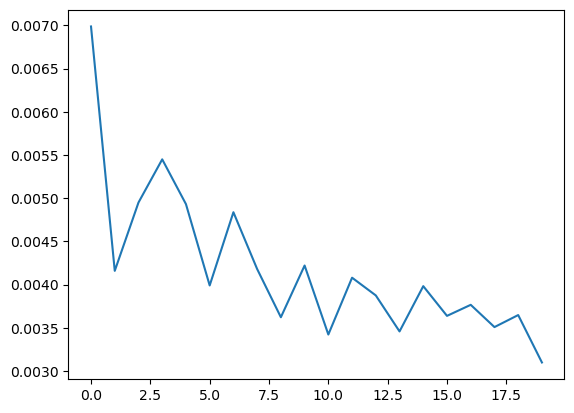

In [59]:
optimality_gap.plot()

<Axes: xlabel='Store'>

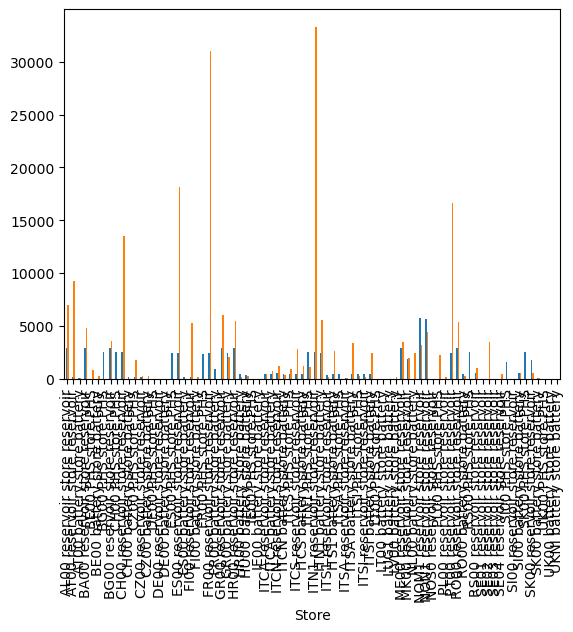

In [60]:
pd.DataFrame([e_initial.loc[n2.snapshots[0]], n_opt.stores_t.e.loc[n1.snapshots[-1]]]).T.plot.bar(legend=False)

Store
100_220kV Pumped Hydro store Pumped Hydro     867.0
114 Pumped Hydro store Pumped Hydro           828.0
121 Pumped Hydro store Pumped Hydro          1428.0
140 Pumped Hydro store Pumped Hydro           600.0
141 Pumped Hydro store Pumped Hydro           600.0
158 Pumped Hydro store Pumped Hydro           600.0
166 Pumped Hydro store Pumped Hydro             9.0
205 Pumped Hydro store Pumped Hydro           918.0
228 Pumped Hydro store Pumped Hydro           475.0
235 Pumped Hydro store Pumped Hydro          1340.0
25 Pumped Hydro store Pumped Hydro              0.0
266 Pumped Hydro store Pumped Hydro           375.0
268 Pumped Hydro store Pumped Hydro           600.0
279_220kV Pumped Hydro store Pumped Hydro    6271.0
293 Pumped Hydro store Pumped Hydro           754.0
320 Pumped Hydro store Pumped Hydro             0.0
32_220kV Pumped Hydro store Pumped Hydro      580.0
333 Pumped Hydro store Pumped Hydro           185.0
342 Pumped Hydro store Pumped Hydro           168.0
343 Pu

In [314]:
n2.stores.e_initial.round()

Store
100_220kV Pumped Hydro store Pumped Hydro     661.0
114 Pumped Hydro store Pumped Hydro           549.0
121 Pumped Hydro store Pumped Hydro           681.0
140 Pumped Hydro store Pumped Hydro           562.0
141 Pumped Hydro store Pumped Hydro           563.0
158 Pumped Hydro store Pumped Hydro           599.0
166 Pumped Hydro store Pumped Hydro             9.0
205 Pumped Hydro store Pumped Hydro           587.0
228 Pumped Hydro store Pumped Hydro           555.0
235 Pumped Hydro store Pumped Hydro           541.0
25 Pumped Hydro store Pumped Hydro              0.0
266 Pumped Hydro store Pumped Hydro           543.0
268 Pumped Hydro store Pumped Hydro           599.0
279_220kV Pumped Hydro store Pumped Hydro     770.0
293 Pumped Hydro store Pumped Hydro           721.0
320 Pumped Hydro store Pumped Hydro           453.0
32_220kV Pumped Hydro store Pumped Hydro      631.0
333 Pumped Hydro store Pumped Hydro             0.0
342 Pumped Hydro store Pumped Hydro           478.0
343 Pu

In [56]:
e_initial

Store,100_220kV Pumped Hydro store Pumped Hydro,114 Pumped Hydro store Pumped Hydro,121 Pumped Hydro store Pumped Hydro,140 Pumped Hydro store Pumped Hydro,141 Pumped Hydro store Pumped Hydro,158 Pumped Hydro store Pumped Hydro,166 Pumped Hydro store Pumped Hydro,205 Pumped Hydro store Pumped Hydro,228 Pumped Hydro store Pumped Hydro,235 Pumped Hydro store Pumped Hydro,...,479 Pumped Hydro store Pumped Hydro,481 Pumped Hydro store Pumped Hydro,493 Pumped Hydro store Pumped Hydro,51 Pumped Hydro store Pumped Hydro,63 Pumped Hydro store Pumped Hydro,66 Pumped Hydro store Pumped Hydro,72 Pumped Hydro store Pumped Hydro,78_220kV Pumped Hydro store Pumped Hydro,8 Pumped Hydro store Pumped Hydro,98 Pumped Hydro store Pumped Hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
